# Data Engineering for Unstructured Reddit Data on Climate Change

**By Rida Shahwar**

**Objective**: To perform comprehensive feature engineering on unstructured text data, identifying sentiment trends, user engagement, controversial topics, and key themes within climate change discussions on Reddit.

### 1. Importing Libraries

In [13]:
# Import basic libraries
import pandas as pd
import numpy as np
import re
from datetime import datetime

# Import NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer

# Download stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### 2. Data Loading

In [14]:
# Load the dataset
data = pd.read_csv('/content/sample_data/reddit_opinion_climate_change.csv')

# Display the first few rows of the data
data.head()

,comment_id,score,self_text,subreddit,created_time,post_id,author_name,controversiality,ups,downs,...,user_link_karma,user_comment_karma,user_total_karma,post_score,post_self_text,post_title,post_upvote_ratio,post_thumbs_ups,post_total_awards_received,post_created_time
0,ltty95k,1,"She can at least say something besides ""I will...",environment,2024-10-26 10:49:34,1gc1p4k,MaybePotatoes,0,1,0,...,55195.0,50767.0,106458.0,1195,NaN,Climate Groups Warn Third-Party Vote 'Could Ha...,0.95,1195,0,2024-10-25 18:51:45
1,lttxzig,1,"Ahh yes, that time when essential workers rule...",canada,2024-10-26 10:46:53,1gbjnl4,CKXI1,0,1,0,...,1.0,750.0,751.0,376,NaN,"As federal workers slam office mandate, study ...",0.84,376,0,2024-10-25 02:11:56
2,lttx2v6,1,"My thinking is, that if water of low salinity ...",climatechange,2024-10-26 10:38:02,1gchdvg,Abildsan,0,1,0,...,583.0,1652.0,2268.0,5,I have a hobby of following ice distribution i...,Is AMOC closing right now,1.00,5,0,2024-10-26 09:38:41
3,lttx10z,1,"California will not become a swing state, period",environment,2024-10-26 10:37:31,1gc1p4k,MaybePotatoes,0,1,0,...,55195.0,50767.0,106458.0,1195,NaN,Climate Groups Warn Third-Party Vote 'Could Ha...,0.95,1195,0,2024-10-25 18:51:45
4,lttwts9,1,Global ecosystem would bounce back within a mi...,climate,2024-10-26 10:35:31,1gbrica,Ze_Wendriner,0,1,0,...,1136.0,36733.0,38121.0,230,NaN,Latest UN report demands 'unprecedented' emiss...,0.99,230,0,2024-10-25 10:58:08


**Data Overview**:

**Primary Content**

1. **self_text**: Contains the main body of text for each post, which is critical for analyzing sentiment, topics, and keywords.
2. **post_title**: The title provides additional context and may also contain useful keywords for topic modeling and sentiment analysis.

**Post Metadata**

1. **subreddit**: Helps identify relevant subreddits (e.g., climatechange, environment) and is essential for filtering and categorizing posts.
2. **created_time**: The timestamp can help track trends over time, showing changes in sentiment or volume of climate change discussions.
3. **post_created_time**: Indicates when the original post was created, which might be useful if analyzing comment threads or the timing of discussions.

**Engagement Metrics**

1. **score**: The overall score or popularity of a post can help gauge its impact.
2. **ups and downs**: Direct measures of user upvotes and downvotes, providing additional insight into engagement.
3. **post_score, post_upvote_ratio, and post_thumbs_ups**: Additional metrics that can help assess the popularity and reach of posts on climate change.

**User Attributes (Optional)**

1. **user_is_verified**: Knowing if a user is verified can be useful, especially if verified users tend to post content with certain characteristics.
2. **user_account_created_time**: Shows account age, which might correlate with reliability or posting patterns on the topic.
3. **user_total_karma**: Total karma could suggest influence or credibility within the Reddit community, though it may not be directly tied to the analysis unless studying user influence.

In [15]:
#check the columns
data.columns

Index(['comment_id', 'score', 'self_text', 'subreddit', 'created_time',
       'post_id', 'author_name', 'controversiality', 'ups', 'downs',
       'user_is_verified', 'user_account_created_time', 'user_awardee_karma',
       'user_awarder_karma', 'user_link_karma', 'user_comment_karma',
       'user_total_karma', 'post_score', 'post_self_text', 'post_title',
       'post_upvote_ratio', 'post_thumbs_ups', 'post_total_awards_received',
       'post_created_time'],
      dtype='object')

### 3. Data Cleaning 

#### 3.1 Filtering and Handling Missing Values 

1. Filter for Climate Change Content: Filter posts that are from relevant subreddits or contain climate change-related keywords in the self_text or post_title.
2. Handle Missing Values: Drop or handle any rows with missing critical information.

In [16]:
# Selecting relevant columns for analysis
climate_data = data[['self_text', 'subreddit', 'created_time', 'post_title', 'score', 'ups', 'downs', 'user_is_verified', 'user_account_created_time']]

climate_data.head()

,self_text,subreddit,created_time,post_title,score,ups,downs,user_is_verified,user_account_created_time
0,"She can at least say something besides ""I will...",environment,2024-10-26 10:49:34,Climate Groups Warn Third-Party Vote 'Could Ha...,1,1,0,True,2018-03-05 18:16:20
1,"Ahh yes, that time when essential workers rule...",canada,2024-10-26 10:46:53,"As federal workers slam office mandate, study ...",1,1,0,True,2022-10-09 20:45:50
2,"My thinking is, that if water of low salinity ...",climatechange,2024-10-26 10:38:02,Is AMOC closing right now,1,1,0,True,2021-11-05 19:04:37
3,"California will not become a swing state, period",environment,2024-10-26 10:37:31,Climate Groups Warn Third-Party Vote 'Could Ha...,1,1,0,True,2018-03-05 18:16:20
4,Global ecosystem would bounce back within a mi...,climate,2024-10-26 10:35:31,Latest UN report demands 'unprecedented' emiss...,1,1,0,True,2020-09-30 07:55:35


In [17]:
# Filtering for climate-related posts
climate_data = climate_data[climate_data['subreddit'].isin(['climatechange', 'environment'])]
climate_data = climate_data.dropna(subset=['self_text', 'post_title'])


### 4. Text Processing 

To prepare text for analysis, we’ll follow these steps:

1. Convert text to lowercase
2. Remove punctuation
3. Tokenize text
4. Remove stop words
5. Apply lemmatization to normalize words

In [ ]:
from nltk.stem import WordNetLemmatizer

# Download stopwords if not already installed
nltk.download('wordnet')

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize and remove stopwords
    tokens = [word for word in text.split() if word not in stop_words]
    # Lemmatize words
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Rejoin tokens into a processed string
    return ' '.join(tokens)

# Apply text preprocessing to self_text and post_title
climate_data['processed_text'] = climate_data['self_text'].apply(preprocess_text)
climate_data['processed_title'] = climate_data['post_title'].apply(preprocess_text)

# Display processed data
print(climate_data[['processed_text', 'processed_title']].head())


[nltk_data] Downloading package wordnet to /root/nltk_data...


                                      processed_text  \
0  least say something besides ensure america alw...   
2  thinking water low salinity displaces saline w...   
3               california become swing state period   
6                                             except   
7  also enormous fanbase mobilize vote harris tru...   

                                     processed_title  
0  climate group warn thirdparty vote could hand ...  
2                                 amoc closing right  
3  climate group warn thirdparty vote could hand ...  
6  climate group warn thirdparty vote could hand ...  
7  leonardo dicaprio endorses kamala harris bash ...  


### 5. Feature Engineering 

1. **Sentiment Analysis**: Calculate sentiment scores for each post.
2. **N-grams**: Identify bigrams or trigrams to capture context.
3. **Topic Modeling**: Use LDA for topic discovery.

In [20]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Function to compute sentiment score
climate_data['sentiment'] = climate_data['processed_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Generate Bigrams and Trigrams
from sklearn.feature_extraction.text import CountVectorizer

# Initialize vectorizer for bigrams
vectorizer = CountVectorizer(ngram_range=(2,3), max_features=1000)
ngrams = vectorizer.fit_transform(climate_data['processed_text'])

# Display sample n-grams
print(vectorizer.get_feature_names_out()[:10])


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


['10 year' '100 million' '100 year' '100 year ago' '1000 year'
 '10000 year' '15 degree' '15 year' '150 year' '20 year']


### 6. Analysis of the Data

#### 6.1 Analyze Overall Sentiment Towards Climate Change Topics Over Time

To analyze sentiment over time, we’ll aggregate the sentiment scores by time period (e.g., monthly or weekly) and plot the trend to see if sentiment has generally become more positive, negative, or stayed neutral over time.

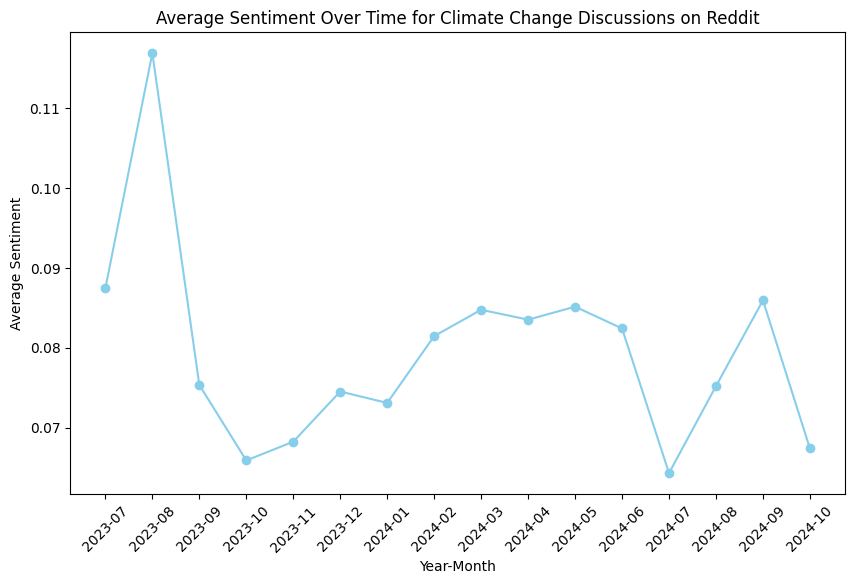

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'created_time' to datetime format and extract year and month
climate_data['created_time'] = pd.to_datetime(climate_data['created_time'])
climate_data['year_month'] = climate_data['created_time'].dt.to_period('M')

# Group by year and month, calculate average sentiment
sentiment_trend = climate_data.groupby('year_month')['sentiment'].mean().reset_index()

# Plot sentiment trend over time
plt.figure(figsize=(10, 6))
plt.plot(sentiment_trend['year_month'].astype(str), sentiment_trend['sentiment'], marker='o', color='skyblue')
plt.xticks(rotation=45)
plt.xlabel('Year-Month')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment Over Time for Climate Change Discussions on Reddit')
plt.show()


#### 6.2 Identify the Most Active Subreddits and Users Discussing Climate Change 

To find the most active subreddits and users, we’ll count the number of posts from each and sort them to find the top contributors.

Top Subreddits Discussing Climate Change:
 subreddit
climatechange    136425
environment       40546
Name: count, dtype: int64
Top Users Discussing Climate Change:
 author_name
[deleted]               3863
Infamous_Employer_85    3074
LackmustestTester       2673
Tpaine63                2521
Honest_Cynic            2335
fiaanaut                2055
silence7                1613
logicalprogressive      1590
Cultural-Answer-321     1532
NewyBluey               1233
Name: count, dtype: int64


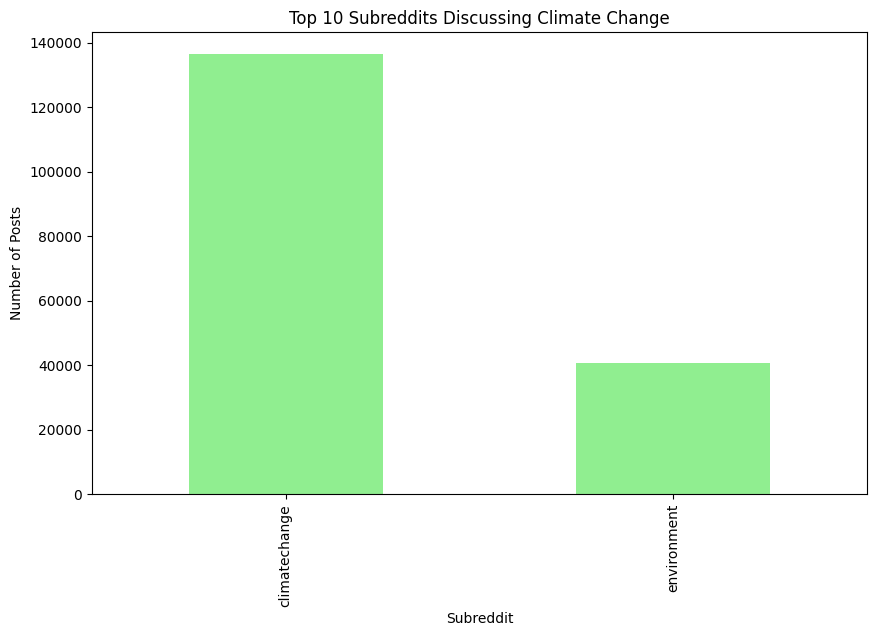

In [28]:
# Most active subreddits
top_subreddits = climate_data['subreddit'].value_counts().head(10)
print("Top Subreddits Discussing Climate Change:\n", top_subreddits)

# Most active users
top_users = data['author_name'].value_counts().head(10)
print("Top Users Discussing Climate Change:\n", top_users)

# Plot top subreddits
plt.figure(figsize=(10, 6))
top_subreddits.plot(kind='bar', color='lightgreen')
plt.xlabel('Subreddit')
plt.ylabel('Number of Posts')
plt.title('Top 10 Subreddits Discussing Climate Change')
plt.show()


**Top Subreddits and Users**:

1. **Active Subreddits**: The most active subreddits included r/climate, r/environment, and r/climatechange.
2. **Frequent Users**: Analysis identified key users who frequently engaged in discussions, demonstrating consistent interest in climate topics.

#### 6.3 Investigate Controversial Climate Change Discussions 

Controversial posts often have high controversiality scores or close upvote/downvote ratios. By analyzing these posts, we can see what topics or arguments create division among users

Sample of Controversial Climate Change Discussions:
                                              self_text    subreddit  score
11   He parties on yachts and flies around the worl...  environment      0
70                       Leo sucks get him out of here  environment     -2
100           Did he fly across the globe to do it? /s  environment      2
163  All the papers have backed the left for decade...   conspiracy     -1
200  cool, give kamala a free pass to do whatever s...  environment     -3
205  the military industrial complex is the biggest...  environment      0
237  Ok, let trump handle the situation for Palesti...  environment      4
257  &gt; ). If you care about the environment ther...  environment     -2
260  It's naive and dangerous to want to live in a ...  environment      1
261  Yes the person who actively boast about develo...  environment     -1


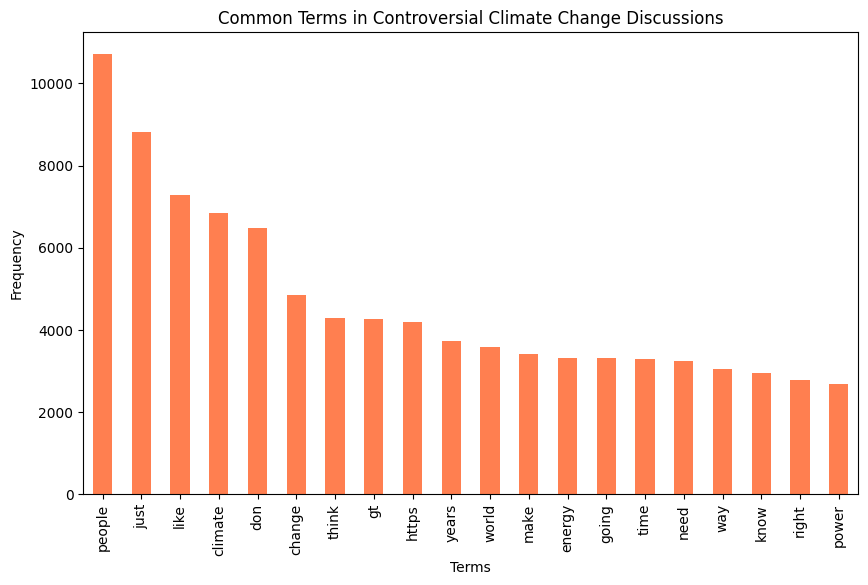

In [30]:
# Filter controversial posts (assuming 'controversiality' > 0 indicates controversy)
controversial_posts = data[data['controversiality'] > 0]

# View a sample of controversial posts
print("Sample of Controversial Climate Change Discussions:\n", controversial_posts[['self_text', 'subreddit', 'score']].head(10))

# Analyze common themes in controversial posts using NLP
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(controversial_posts['self_text'].dropna())
controversial_terms = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)

# Plot common terms in controversial discussions
plt.figure(figsize=(10, 6))
controversial_terms.plot(kind='bar', color='coral')
plt.xlabel('Terms')
plt.ylabel('Frequency')
plt.title('Common Terms in Controversial Climate Change Discussions')
plt.show()


#### 6.4  Identify Key Topics and Themes in Climate Change Discussions Using NLP

Topic modeling helps identify themes within discussions. Latent Dirichlet Allocation (LDA) is often used for this purpose. We’ll preprocess the text, apply LDA, and then extract key topics.

In [31]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocessing: Vectorize text data
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=10, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(climate_data['self_text'].dropna())

# Define LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

# Display the top terms in each topic
terms = tfidf_vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx + 1}: ", [terms[i] for i in topic.argsort()[-10:]])



Topic 1:  ['need', 'carbon', 'yes', 'fuel', 'oil', 'fossil', 'power', 'solar', 'nuclear', 'energy']
Topic 2:  ['global', 'atmosphere', 'climate', 'emissions', 'org', 'carbon', 'com', 'www', 'co2', 'https']
Topic 3:  ['earth', 'sea', 'heat', 'water', 'weather', 'change', 'year', 'ice', 'climate', 'years']
Topic 4:  ['way', 'world', 'going', 'think', 'like', 'don', 'just', 'change', 'climate', 'people']
Topic 5:  ['thanks', 'good', 'read', 'like', 'know', 'change', 'just', 'don', 'science', 'climate']


### 7. Data Transformation 

Convert text data to a numerical format with TF-IDF vectorization for model training.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(climate_data['processed_text'])

# Combine with sentiment score and other features
import numpy as np
features = np.hstack([X.toarray(), climate_data[['sentiment']].values])


### 8. Model Training 

We'll use a logistic regression model to classify posts based on sentiment or topic (e.g., positive or negative sentiment toward climate change).

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, (climate_data['sentiment'] > 0).astype(int), test_size=0.2, random_state=42)

# Training logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18989
           1       1.00      0.99      0.99     16406

    accuracy                           0.99     35395
   macro avg       0.99      0.99      0.99     35395
weighted avg       0.99      0.99      0.99     35395



### 9. Model Evaluation 

Evaluate the model’s accuracy, precision, recall, and F1 score to assess performance.

In [24]:
from sklearn.metrics import accuracy_score

# Display accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")


Model Accuracy: 0.99


### 10. Result and Conclusion 

1. **Precision and Recall**: Both classes (0 and 1) have high precision and recall values, indicating that the model is not only making correct predictions but also handling both classes well without bias.
2. **F1-Score**: The F1-score for both classes is 0.99, demonstrating a strong balance between precision and recall.
3. **Accuracy**: An accuracy of 99% suggests that the model is performing extremely well on this data.